In [1]:
# All imports

import numpy as np
import os
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import torch as th
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.manifold import TSNE

In [2]:
# Declare encoder decoder and Unet

class ResBlock(nn.Module):
    
    def __init__(self, input_channels, output_channels, act=nn.LeakyReLU(inplace=True), **conv_parameters):
        super().__init__()
        self.convin = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.convout = nn.Conv2d(output_channels, output_channels, **conv_parameters)
        self.act = act
        
    def forward(self,x):
        x = self.act(self.convin(x))
        x = self.convout(x) + x
        return x

class Encoder(nn.Module):
    
    def __init__(self, n_layers=4, root_features=32, expansion_factor=2):
        super().__init__()
        self.output_channels = [root_features]
        conv_i = []
        bn_i = []
        for i in range(n_layers):
            in_ch, out_ch = self.output_channels[-1], self.output_channels[-1]*expansion_factor 
            conv_i += [ ResBlock(in_ch, out_ch, kernel_size=3, padding=1, bias=False) ]
            bn_i += [ nn.BatchNorm2d(out_ch) ]
            self.output_channels += [out_ch]
        self.conv_i = nn.ModuleList(conv_i)
        self.bn_i = nn.ModuleList(bn_i)
        self.act = nn.LeakyReLU(inplace=True)
        
    def forward(self,x):
        outputs = [x]
        for bn,conv in zip(self.bn_i,self.conv_i):
            x = self.act(bn(conv(x)))
            outputs += [x]
            x = x[:,:,::2,::2]
        return outputs
    
class Decoder(nn.Module):
    
    def __init__(self, encoder_n_layers=4, encoder_root_features=32, encoder_expansion_factor=2, skip=True):
        super().__init__()
        self.output_channels = [encoder_root_features*encoder_expansion_factor**encoder_n_layers]
        self.skip = skip
        self.encoder_n_layers = encoder_n_layers
        upconv_i = []
        conv_i = []
        bn_i = []
        for i in range(encoder_n_layers-1):
            in_ch, out_ch = self.output_channels[-1], self.output_channels[-1]//encoder_expansion_factor 
            upconv_i += [ nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2*2, stride=2, padding=1) ]
            conv_i += [ nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False) ]
            bn_i += [ nn.BatchNorm2d(out_ch) ]
            self.output_channels += [out_ch]
        self.upconv_i = nn.ModuleList(upconv_i)
        self.bn_i = nn.ModuleList(bn_i)
        self.conv_i = nn.ModuleList(conv_i)
        self.act = nn.LeakyReLU(inplace=True)
        
    def forward(self,encoder_outputs):
        x = encoder_outputs[-1]
        outputs = []
        for i in range(self.encoder_n_layers-1):
            if self.skip : 
                x = self.act(self.upconv_i[i](x) + encoder_outputs[-(i+2)])
            else : 
                x = self.act(self.upconv_i[i](x))
            x = self.act(self.bn_i[i](self.conv_i[i](x)))
            outputs += [x]
        return outputs
    
class Unet(nn.Module):
    
    def __init__(self, input_channels, output_channels, n_layers=4, root_features=32, expansion_factor=2, skip=True):
        super().__init__()
        self.skip = skip
        self.encoder = Encoder(n_layers=n_layers, root_features=root_features, expansion_factor=expansion_factor)
        self.decoder = Decoder(encoder_n_layers=n_layers, encoder_root_features=root_features, encoder_expansion_factor=expansion_factor, skip=skip)
        self.conv_in = nn.Conv2d(input_channels, root_features, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(self.decoder.output_channels[-1], output_channels, kernel_size=3, padding=1)
    
    def forward(self,x):
        encoder_outputs = self.encoder(self.conv_in(x))
        decoder_outputs = self.decoder(encoder_outputs)
        decoder_outputs[-1] = self.conv_out(decoder_outputs[-1])
        return decoder_outputs
    


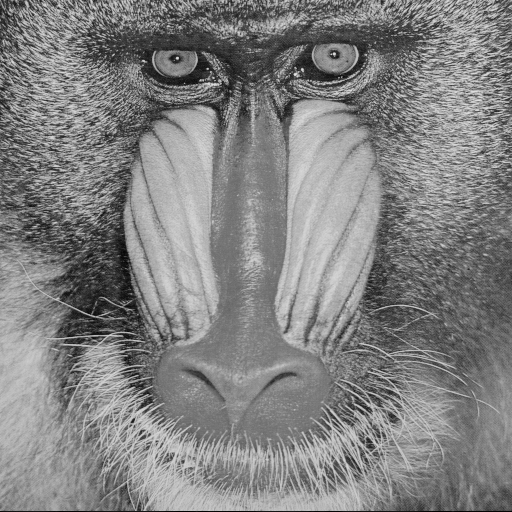

In [3]:
# load image
from PIL import Image
from PIL.ImageOps import crop
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from skimage import data, exposure, filters
from scipy.ndimage.measurements import label
from scipy.ndimage import gaussian_filter as G
from scipy.ndimage import sobel as S
from skimage import transform
from sklearn.cluster import DBSCAN
import numpy as np

im = Image.open("baboon.png").convert('L')
im

/home/mviti/miniconda3/envs/torch_light/lib/python3.7/site-packages/torchvision/transforms/functional.py:169: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378124864/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.as_tensor(np.asarray(pic))


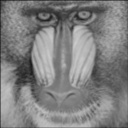

In [4]:
transform = transforms.Compose( [transforms.PILToTensor(), transforms.ConvertImageDtype(th.float)] )
dwn_sample = 4
down_sample = nn.AvgPool2d(kernel_size=dwn_sample*2+1, stride=dwn_sample, padding=dwn_sample)
up_sample = th.nn.UpsamplingBilinear2d(scale_factor=dwn_sample)

x = transform(im)[np.newaxis]
dx = down_sample(x)
ux = up_sample(dx)

dx_i =  transforms.ToPILImage()(dx[0])
ux_i =  transforms.ToPILImage()(ux[0])
dx_i

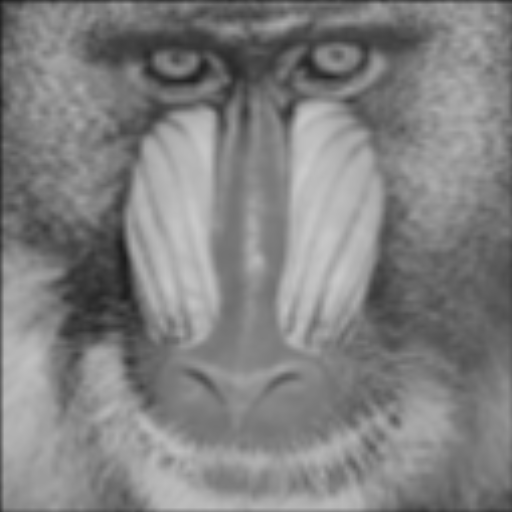

In [5]:
# rescale using Bilinear interpolation
# note the image remains in the same scale space only with filled in pixels
ux_i

Text(0.5, 1.0, 'upsampled')

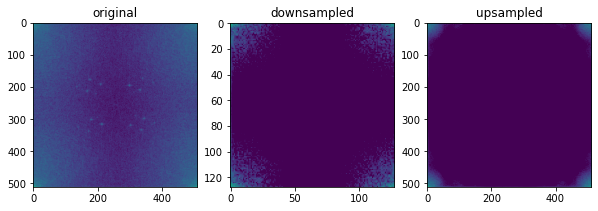

In [6]:
from scipy import fftpack
from matplotlib.colors import LogNorm

x_fft = fftpack.fft2(x.numpy()[0,0])
dx_fft = fftpack.fft2(dx.numpy()[0,0])
ux_fft = fftpack.fft2(ux.numpy()[0,0])

# Show the results
fig,axs = plt.subplots(1,3, figsize=(10,10))

axs[0].imshow(np.abs(x_fft), norm=LogNorm(vmin=5))
axs[0].set_title('original')
axs[1].imshow(np.abs(dx_fft), norm=LogNorm(vmin=5))
axs[1].set_title('downsampled')
axs[2].imshow(np.abs(ux_fft), norm=LogNorm(vmin=5))
axs[2].set_title('upsampled')



In [9]:
mse = nn.MSELoss()

x = x.cuda()
ux = ux.cuda()
dx = dx.cuda()
model = Unet(1,1,root_features=32)
model = model.cuda()
optim = th.optim.Adam(model.parameters(), lr=0.000001)
n_iters = 10000
losses = []
%matplotlib inline

for i in range(n_iters):
    
    unet_output = model(ux)[-1]
    pred_x = th.nn.functional.sigmoid(unet_output)
    
    # output loss
    pixel_loss = mse(pred_x, x)
    
    loss = pixel_loss 
    
    loss.backward()
    losses += [pixel_loss.item()]
    optim.step()
    print('loss : {} iter: {}/{}     '.format(loss.item(),i,n_iters), end='\r')


Text(0.5, 1.0, '|x_fft|')

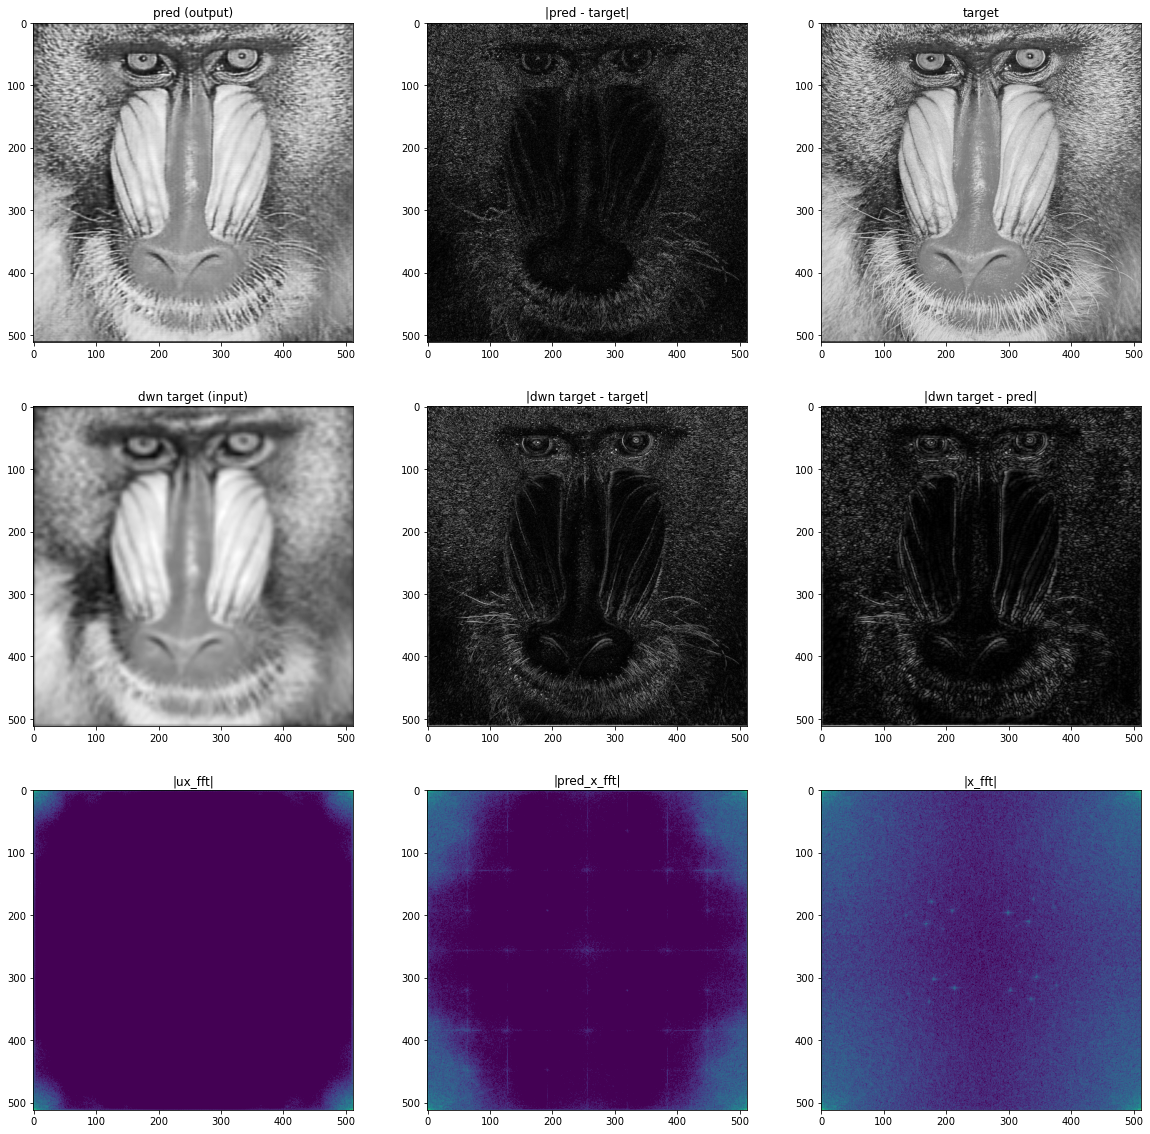

In [10]:
pred_x_i =  transforms.ToPILImage()((pred_x)[0].detach().cpu())
diff_x_i =  transforms.ToPILImage()((x-pred_x).abs()[0].detach().cpu())
diff_u_i =  transforms.ToPILImage()((x-ux).abs()[0].detach().cpu())
diff_x_u_i =  transforms.ToPILImage()((pred_x-ux).abs()[0].detach().cpu())

#x_fft = fftpack.fft2(x.numpy()[0,0])
pred_x_fft = fftpack.fft2(pred_x.cpu().detach().numpy()[0,0])
#ux_fft = fftpack.fft2(ux.numpy()[0,0])

x_i =  transforms.ToPILImage()(x[0].detach().cpu())
fig,axs=plt.subplots(3,3, figsize=(20,20))

axs[0,0].imshow(pred_x_i, cmap='gray')
axs[0,0].set_title('pred (output)')

axs[0,1].imshow(diff_x_i, cmap='gray')
axs[0,1].set_title('|pred - target|')

axs[0,2].imshow(x_i, cmap='gray')
axs[0,2].set_title('target')

axs[1,0].imshow(ux_i, cmap='gray')
axs[1,0].set_title('dwn target (input)')

axs[1,1].imshow(diff_u_i, cmap='gray')
axs[1,1].set_title('|dwn target - target|')

axs[1,2].imshow(diff_x_u_i, cmap='gray')
axs[1,2].set_title('|dwn target - pred|')

axs[2,0].imshow(np.abs(ux_fft), norm=LogNorm(vmin=5))
axs[2,0].set_title('|ux_fft|')

axs[2,1].imshow(np.abs(pred_x_fft), norm=LogNorm(vmin=5))
axs[2,1].set_title('|pred_x_fft|')

axs[2,2].imshow(np.abs(x_fft), norm=LogNorm(vmin=5))
axs[2,2].set_title('|x_fft|')



Text(0, 0.5, 'MSE')

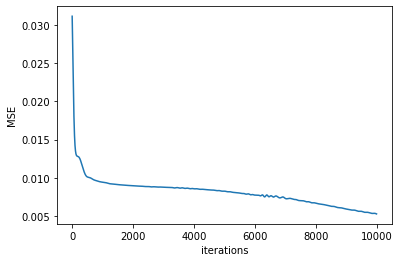

In [11]:
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('MSE')